In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.tree import DecisionTreeClassifier, _tree, plot_tree
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
X = train.drop("Survived", axis=1)
y = train["Survived"]

clf = DecisionTreeClassifier(max_depth=3, random_state=1234)
model = clf.fit(X, y)

In [3]:
def tree_to_json(tree, feature_names, class_names):
    """Convert decision tree model to human readable json of rules
    :param tree: input tree model
    :param feature_names: list of input features used in the input model
    :param class_names: list of classes present in label (dependent variable), [0, 1] in case of binary classification
    :return: json of rules
    """
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]
    
    paths = []
    path = []
    
    def recurse(node, path, paths):
        # order of the list (tree_.feature) corresponds to a tree traversal starting with left node
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)
    
    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    fin_dict = {}
    fin_dict["list_of_rules"] = []
    
    for path in paths:
        antecedent = []
        names = []
        for p in path[:-1]:
            p_split = re.sub(r"[\()]", "", str(p)).split()
            
            # value list of feature in antecedent
            if p_split[1] == "<=":
                t_value = [None, float(p_split[2]) + 10e-8]
            else:
                t_value = [float(p_split[2]) + 10e-8, None]
                
            # if feature already present in antecedent
            if p_split[0] in names:
                this_values = antecedent[names.index(p_split[0])]["values"] # extract existing value list of the feature

                # lower limit of value list
                if not this_values[0][0]:
                    this_values[0][0] = -np.inf # convert None to -inf
                if not t_value[0]:
                    t_value[0] = -np.inf # convert None to -inf
                this_values[0][0] = max(this_values[0][0], t_value[0]) # new lower limit of value list: max(existing, new)
                if this_values[0][0] == -np.inf:
                    this_values[0][0] = None # again conver -nf to None

                # upper limit of value list
                if not this_values[0][1]:
                    this_values[0][1] = np.inf # convert None to inf
                if not t_value[1]:
                    t_value[1] = np.inf # convert None to inf
                this_values[0][1] = min(this_values[0][1], t_value[1]) # new upper limit of value list: min(existing, new)
                if this_values[0][1] == np.inf:
                    this_values[0][1] = None # again convert inf to None

            # if feature not already present in antecedent,
            else:
                names.append(p_split[0])
                antecedent_dict = {}
                antecedent_dict["values"] = [t_value]
                antecedent_dict["name"] = p_split[0]
                antecedent_dict["type"] = "numerical"
                antecedent.append(antecedent_dict)

        lor_dict = {}
        lor_dict["antecedent"] = antecedent

        classes = path[-1][0][0]
        model_class = np.argmax(classes)

        # append rule to list_of_rules only if class==1
        if class_names[model_class] == 1:
            fin_dict["list_of_rules"].append(lor_dict)

    fin_dict["default_class"] = 0
    return fin_dict

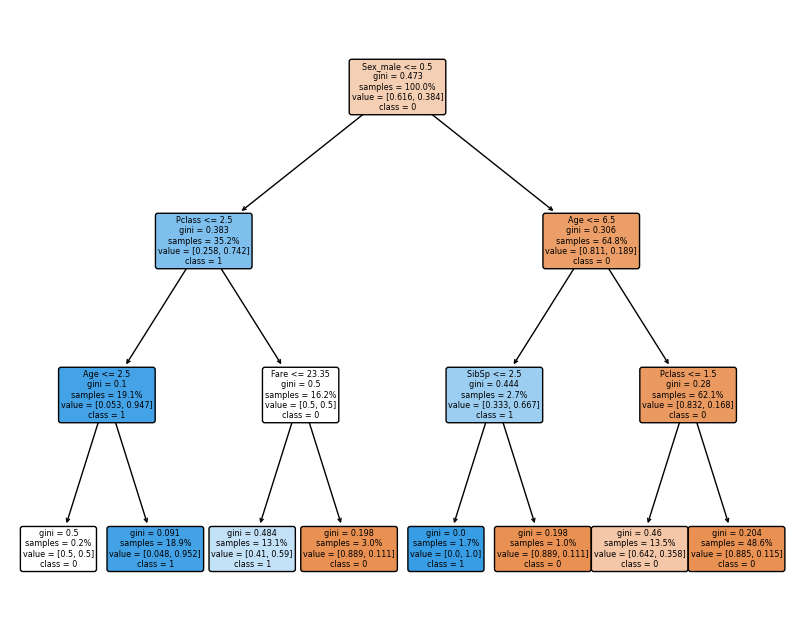

In [4]:
plt.figure(figsize=(10, 8))
plot_tree(clf,
          feature_names=list(X.columns),
          class_names=clf.classes_.astype(str),
          rounded=True,
          filled=True,
          proportion=True);

In [5]:
tree_to_json(clf, list(X.columns), clf.classes_)

{'list_of_rules': [{'antecedent': [{'values': [[None, 0.5000001]],
     'name': 'Sex_male',
     'type': 'numerical'},
    {'values': [[None, 2.5000001]], 'name': 'Pclass', 'type': 'numerical'},
    {'values': [[2.5000001, None]], 'name': 'Age', 'type': 'numerical'}]},
  {'antecedent': [{'values': [[None, 0.5000001]],
     'name': 'Sex_male',
     'type': 'numerical'},
    {'values': [[2.5000001, None]], 'name': 'Pclass', 'type': 'numerical'},
    {'values': [[None, 23.350000100000003]],
     'name': 'Fare',
     'type': 'numerical'}]},
  {'antecedent': [{'values': [[0.5000001, None]],
     'name': 'Sex_male',
     'type': 'numerical'},
    {'values': [[None, 6.5000001]], 'name': 'Age', 'type': 'numerical'},
    {'values': [[None, 2.5000001]], 'name': 'SibSp', 'type': 'numerical'}]}],
 'default_class': 0}